In [ ]:
!pip install pydicom

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Function to calculate HU values
def calculate_hu(dicom_image):
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    hu_values = dicom_image.pixel_array * slope + intercept
    return hu_values

In [ ]:
# Function to segment image based on HU values
def segment_image(hu_values, hu_range=(40, 90)):
    segmented_image = np.where((hu_values >= hu_range[0]) & (hu_values <= hu_range[1]), hu_values, 0)
    return segmented_image

In [ ]:

# Function to extract features
def extract_features(segmented_image):
    non_zero_values = segmented_image[segmented_image > 0]
    if len(non_zero_values) == 0:
        return None  # No haemorrhage detected

    features = {
        'min_hu': np.min(non_zero_values),
        'max_hu': np.max(non_zero_values),
        'avg_hu': np.mean(non_zero_values),
        'size': len(non_zero_values)
    }
    return features

In [ ]:
def determine_timing(hu_value):
    if hu_value >= 40:
        return 'Acute, (recent)'
    elif 20 <= hu_value < 40:
        return 'Subacute, (Somewhat older)'
    else:
        return 'Chronic, (Old enough)'

In [ ]:
# Function to train the KNN classifier
def train_knn(features, labels):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(features, labels)
    return knn

In [ ]:
# Function to classify a new image
def classify_image(knn, features):
    return knn.predict([features])[0]

In [ ]:
# Visualization function
def show_images(original, segmented):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original HU Image")
    plt.imshow(original, cmap='gray')
    plt.colorbar(label='HU')

    # Segmented image
    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    plt.imshow(segmented, cmap='gray')
    plt.colorbar(label='HU')

    plt.show()


In [ ]:
# Example workflow
def process_dicom_file(file_path, knn=None, visualize = True):
    dicom_image = pydicom.dcmread(file_path)

    if 'pixel_array' not in dir(dicom_image):
        return "No pixel data found in DICOM file"

    hu_values = calculate_hu(dicom_image)
    segmented_image = segment_image(hu_values)
    features = extract_features(segmented_image)

    if features is None:
        return "No haemorrhage detected"

    # Determine the timing based on the average HU value
    timing = determine_timing(features['avg_hu'])

    result = {'features': features, 'timing': timing}

    if knn is not None:
        classification = classify_image(knn, list(features.values()))
        result['classification'] = classification

    if visualize:
        show_images(hu_values, segmented_image)

    return result

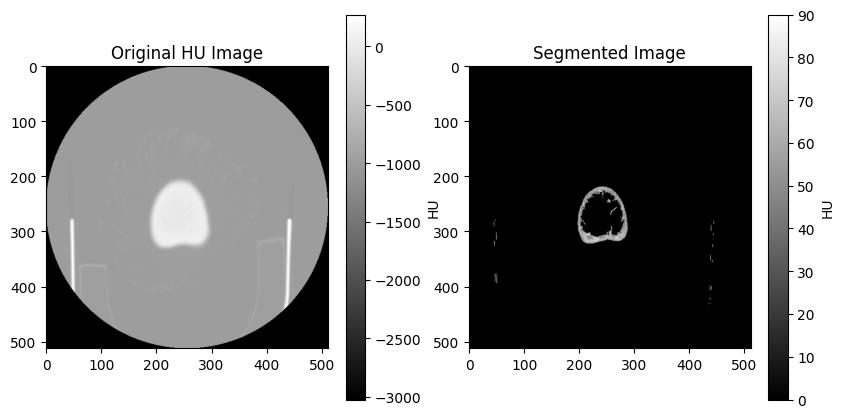

{'features': {'min_hu': 40.0, 'max_hu': 90.0, 'avg_hu': 54.91353996737357, 'size': 3065}, 'timing': 'Acute, (recent)', 'classification': 'Type1'}


In [ ]:
# Example usage
# Training data (example)
train_features = [
    [50, 90, 65, 450],
    [45, 85, 60, 500],
    [40, 90, 55, 400],
    [35, 85, 50, 350]
    # Feature vector [min_hu, max_hu, avg_hu, size]

]
train_labels = ['Type1', 'Type2', 'Type3', 'Type4']

knn = train_knn(train_features, train_labels)

# Process a new DICOM file
result = process_dicom_file("/content/CT000143.dcm", knn)
print(result)